In [1]:
import matplotlib.pyplot as plt
import numpy as np
import opt_einsum
import scipy
from numba import jit
from scipy.interpolate import BSpline

In [2]:
import numpy as np

In [2]:
class BSplineBasis1D:
    def __init__(self, h, p, C):
        self.h = h #Number of basis functions (should equal n_el p + 1, where n_el is the number of elements)
        self.p = p  #Polynomial degree
        self.C = C #Continuity
        self.knot_vector = np.zeros(self.p+1)
        self.knot_vector = np.append(self.knot_vector, np.repeat(np.linspace(0, 1, int((self.h - self.p - 1)/(self.p - self.C)) + 2)[1:-1], self.p - self.C))
        self.knot_vector = np.append(self.knot_vector, np.ones(self.p+1))

    def basis_function(self, n, p, x, knots):
        c = np.zeros(self.h)
        c[n] = 1
        bspline = BSpline(knots, c, p)
        return bspline(x)
    
    def forward(self, x):
        basis_values = np.zeros((x.shape[0],self.h))
        for n in range(self.h):
            basis_values[:, n] = self.basis_function(n, self.p, x, self.knot_vector)
        return basis_values
    
    def basis_gradient(self, n, p, x, knots):
        c = np.zeros(self.h)
        c[n] = 1
        bspline = BSpline(knots, c, p)
        bspline_derivative = bspline.derivative(1)
        return bspline_derivative(x)
    
    def grad(self, x):
        basis_gradients = np.zeros((x.shape[0],self.h))
        for n in range(self.h):
            basis_grad = self.basis_gradient(n, self.p, x, self.knot_vector)
            basis_gradients[:, n] = basis_grad
        return basis_gradients

    def plot_1d_basis(self):
        knots = self.knot_vector
        resolution = 1000
        x_values = np.linspace(knots[self.p], knots[-self.p-1], resolution)  # Adjusted range for x_values
        basis_matrix = self.forward(x_values)
        plt.figure(figsize=(8, 6))
        for i in range(self.h):
            plt.plot(x_values, basis_matrix[:,i], label=f'Basis {i}')
        plt.title(f'1D B-spline Basis Functions')
        plt.xlabel('x')
        plt.ylabel('Basis Values')
        plt.xticks(np.array([0,1,2,3,4])/4)
        plt.legend()
        plt.grid(True)
        # plt.savefig("BSpline1D.svg", bbox_inches='tight', transparent=True)
        plt.show()
        
    def plot_1d_basis_gradients(self):
        knots = self.knot_vector
        resolution = 1000
        min_knot = knots[self.p]
        max_knot = knots[-self.p-1]
        x_values = np.linspace(min_knot, max_knot, resolution)  # Use full knot span for x_values
        basis_gradients_matrix = self.grad(x_values)
        plt.figure(figsize=(8, 6))
        for i in range(self.h):
            plt.plot(x_values, basis_gradients_matrix[:, i], label=f'Gradient {i}')
        plt.title(f'Gradients of 1D B-spline Basis Functions')
        plt.xlabel('x')
        plt.ylabel('Gradient Values')
        plt.legend()
        plt.grid(True)
        # plt.savefig("BSplinegrad1D.svg", bbox_inches='tight', transparent=True)
        plt.show()

In [20]:
basis = BSplineBasis1D(h=4, p=3, C=2)

In [ ]:
basis.basis_function

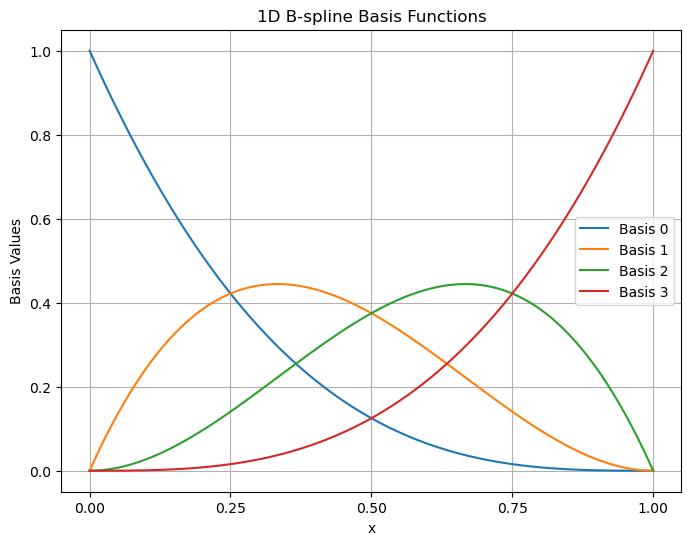

In [21]:
basis.plot_1d_basis()

In [ ]:
100/5/5/2/2

In [ ]:
# Define the 2D B-spline basis generator
class BSplineBasis2D:
    def __init__(self, knots_x, knots_y, polynomial_order):
        self.basis_1d_x = BSplineBasis1D(knots_x, polynomial_order)
        self.basis_1d_y = BSplineBasis1D(knots_y, polynomial_order)

    def forward(self, x):
        bx = self.basis_1d_x.forward(x[:,0])
        by = self.basis_1d_y.forward(x[:,1])
        basis_values_2d = opt_einsum.contract('ni,nj->nij', bx, by)
        basis_values_2d = basis_values_2d.reshape((basis_values_2d.shape[0],basis_values_2d.shape[1]*basis_values_2d.shape[2]))
        return basis_values_2d
    
    def grad(self, x):
        bx = self.basis_1d_x.forward(x[:,0])
        by = self.basis_1d_y.forward(x[:,1])
        gx = self.basis_1d_x.grad(x[:,0])
        gy = self.basis_1d_y.grad(x[:,1])
        basis_gradients_2d_x = opt_einsum.contract('ni,nj->nij', gx, by)
        basis_gradients_2d_y = opt_einsum.contract('ni,nj->nij', bx, gy)
        basis_gradients_2d = np.zeros((basis_gradients_2d_x.shape[0],basis_gradients_2d_x.shape[1], basis_gradients_2d_x.shape[2], 2))
        basis_gradients_2d[:,:,:,0] = basis_gradients_2d_x
        basis_gradients_2d[:,:,:,1] = basis_gradients_2d_y
        basis_gradients_2d = basis_gradients_2d.reshape((basis_gradients_2d.shape[0],basis_gradients_2d.shape[1]*basis_gradients_2d.shape[2],basis_gradients_2d.shape[3]))
        return basis_gradients_2d
    
    def plot_2d_bspline_basis(self):
        resolution = 100
        x_0, x_1 = np.array(np.mgrid[0:1:resolution*1j, 0:1:resolution*1j])
        x = np.vstack([x_0.ravel(), x_1.ravel()]).T
        basis_values_2d = self.forward(x)
        
        num_basis_x = self.basis_1d_x.num_basis
        num_basis_y = self.basis_1d_y.num_basis
        
        fig, axes = plt.subplots(num_basis_x, num_basis_y, figsize=(num_basis_y*4, num_basis_x*3))
        
        for i in range(num_basis_x):
            for j in range(num_basis_y):
                ax = axes[i, j] if num_basis_x > 1 and num_basis_y > 1 else axes[max(i, j)]
                idx = i * num_basis_y + j
                z = basis_values_2d[:, idx].reshape(resolution, resolution)
                c = ax.contourf(x_0, x_1, z, levels=20)
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Basis ({i},{j})')
                ax.set_xlabel('x')
                ax.set_ylabel('y')

        plt.tight_layout()
        # plt.savefig("BSpline2D.svg", bbox_inches='tight', transparent=True)
        plt.show()
        
    def plot_2d_bspline_basis_gradients(self):
        resolution = 100
        x_0, x_1 = np.array(np.mgrid[0:1:resolution*1j, 0:1:resolution*1j])
        x = np.vstack([x_0.ravel(), x_1.ravel()]).T
        basis_gradients_2d = self.grad(x)

        num_basis_x = self.basis_1d_x.num_basis
        num_basis_y = self.basis_1d_y.num_basis

        fig, axes = plt.subplots(num_basis_x, num_basis_y, figsize=(num_basis_y*4, num_basis_x*3))

        for i in range(num_basis_x):
            for j in range(num_basis_y):
                ax = axes[i, j] if num_basis_x > 1 and num_basis_y > 1 else axes[max(i, j)]
                idx = i * num_basis_y + j
                z = np.linalg.norm(basis_gradients_2d[:, idx], axis=-1).reshape(resolution, resolution)
                c = ax.contourf(x_0, x_1, z, levels=20)
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Gradient ({i},{j})')
                ax.set_xlabel('x')
                ax.set_ylabel('y')

        plt.tight_layout()
        # plt.savefig("BSplinegrad2D.svg", bbox_inches='tight', transparent=True)
        plt.show()


# Example usage of the 2D B-spline basis generator
knots1dx = np.array([0,0,0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1,1,1])
knots1dy = np.array([0,0,0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1,1,1])
polynomial_order = 3

# Create the 2D B-spline basis generator
basis_2d = BSplineBasis2D(knots1dx, knots1dy, polynomial_order)

# Plot the 2D B-spline basis functions
basis_2d.plot_2d_bspline_basis()
basis_2d.plot_2d_bspline_basis_gradients()